# Analysis of rhythmic activity *for the practicing neuroscientist* <a id="top"></a>

<div class="alert alert-block alert-info">
_**Synopsis**_ <br><br>
**Data:** 100 trials of 1 s of local field potential and spike train data sampled at 1000 Hz. <br>

**Goal:** Characterize the coupling between the spike and field activity.<br>

**Tools:** Fourier transform, spectrum, coherence, phase, generalized linear models.
</div>

* [Introduction](#.)
* [Data analysis](#data-analysis)
    * [Visual inspection](#visual-inspection)
    * [Mean, variance, and standard deviation](#mean)
    * [The autocovariance](#autocovariance)
    * [Power spectral density](#power-spectral-density)
        * [The spectrum](#spectrum)
        * [The discrete Fourier transform in Python](#dft)
        * [The Nyquist frequency](#nyquist-frequency)
        * [The frequency resolution](#frequency-resolution)
    * [Decibel scaling](#decibel-scaling)
    * [The spectrogram](#the-spectrogram)
* [Summary](#summary)

## Introduction
In the previous sections, we focused on two types of data: field data (e.g., EEG, ECoG, LFP) and spiking data (i.e., action potentials), and we developed techniques to analyze these data. In this chapter, we consider the simultaneous observation of both data types. We analyze these multiscale data using the techniques developed in previous chapters and focus specifically on computing the coherence between the spike and field recordings. Understanding the relations between activity recorded at different spatial scales (i.e., a macroscopic field and microscopic spikes) remains an active research area.

### Case study data
Our experimental collaborator has implanted an electrode in rat hippocampus as the animal performs a task requiring navigation and decision making. From these data, he is able to extract the local field potential (LFP) as well as the spiking activity of a single neuron. He would like to characterize how these multiscale data—the population field activity and the single neuron spiking activity—relate. Based on existing evidence in the literature and experimental intuition, he expects that rhythmic activity in the LFP impacts the probability that a spike will occur. As his collaborator, we will help him to develop tools to examine this hypothesis. He provides us with 100 trials of simultaneous LFP and spike train data with a sampling frequency of 1000 Hz. The duration of each trial is 1 s, corresponding to a fixed temporal interval following a particular decision of the rat.

### Goals
Our goal is to understand the coupling between the spiking activity and the LFP following the stimulus. To do so, we analyze the multiscale data recorded simultaneously. To assess this coupling, we will start with two visualizations of the data: the spike-triggered average and the field-triggered average. We then compute the spike-field coherence, a coupling measure that builds upon previous development of the Fourier transform and spectrum. We also examine how the firing rate impacts measures of coupling and how to mitigate this impact.

### Tools
In this chapter, we focus primarily on computing the spike-field coherence. Development of this measure makes use of skills developed in previous sections. In computing the spike-field coherence, we continue to utilize the Fourier transform. We also consider how generalized linear models (GLMs) can be used to construct a measure of spike-field association with an important advantage over the spike-field coherence.


## Data analysis<a id="data-analysis"></a>

We will go through the following steps to analyze the data:

1. [Visual inspection](#visual-inspection)
2. [Mean, variance, and standard deviation](#mean)
3. [The autocovariance](#autocovariance)
4. [Power spectral density](#power-spectral-density)
5. [Decibel scaling](#decibel-scaling)
6. [The spectrogram](#the-spectrogram)

### Step 1: Visual inspection<a id="visual-inspection"></a>

We begin the analysis by visualizing examples of the simultaneously recorded spike train and LFP data. Let’s load these multi- scale data into MATLAB and plot the activity of the first trial:<a id='fig:11-1'></a>

In [4]:
# Prepare the modules and plot settings
import scipy.io as sio
import matplotlib.pyplot as plt
from matplotlib.pyplot import xlabel, ylabel, plot, show, title
from matplotlib import rcParams
import setup
%matplotlib inline
rcParams['figure.figsize'] = (12,3)

In [37]:
setup.set_defaults()

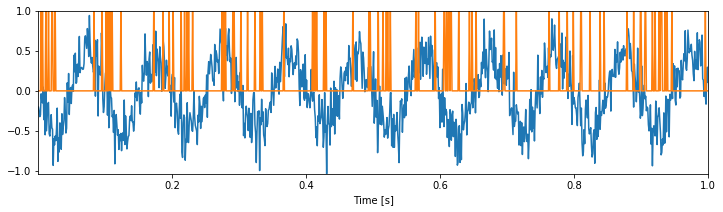

In [35]:
data = sio.loadmat('Ch11-spikes-LFP-1.mat')  # Load the multiscale data,
y = data['y']
t = data['t'].reshape(-1)
n = data['n']
plot(t,y[1,:])
plot(t,n[1,:])
xlabel('Time [s]')  # Label the time axis
plt.autoscale(tight=True)  # Minimize white space

<div class="alert alert-block alert-warning">
**Array shapes:** The `reshape()` function lets us change the shape of an array. `reshape(-1)` tells Python to reshape the array into a vector with as many elements as are in the array. Mathematically, a vector is a one-dimensional array. In Python, the difference is that a vector is indexed by a single number, while an array is indexed by multiple numbers. After reshaping, we can look at the number at index 0 of `t` using `t[0]`. If we don't reshape first, we need to use `t[0, 0]` to get the same result, so reshaping the array isn't required, but it is more convenient. There is a nice explanation of array shapes [here](https://stackoverflow.com/questions/22053050/difference-between-numpy-array-shape-r-1-and-r#answer-22074424). 
</div>

The data file consists of three variables, which correspond to the LFP data (`y`, in units of millivolts), the simultaneously recorded spiking activity (`n`), and a time axis (`t`, in units of seconds). Notice that the data are arrays, in which each row indicates a separate trial, and each column indicates a point in time. In this case, the variable `n` is binary; `n[k,i]=1` indicates a spike in trial `k` at time index `i`.

<div class="alert alert-block alert-info">
**Q.** What is the sampling frequency for these data? <br><br>

**A.** We are given the time axis `t`. To compute the sampling frequency, we compute the sampling interval: `dt = t[2]-t[1]` and find `dt = 0.001`. The sampling interval is therefore 1 ms, so the sampling frequency ( $f$ ) is $f = 1/dt = 1000$ Hz.

</div>

The data for this trial are plotted in the [figure](#fig:11-1). Visual inspection immediately suggests that the LFP data exhibit a dominant rhythm. By counting the number of peaks (or troughs) in 1 s of data, we estimate the dominant rhythm to be $\approx$ 10 Hz. However, careful inspection suggests that other features appear in the LFP from this first trial of data (i.e., additional lower-amplitude wiggles in the signal). Let’s keep this in mind as we continue the anal- ysis. To visualize the spikes from the neuron, we plot the activity in the first row of the data matrix (black curve in the [figure](#fig:11-1)); this is a crude representation of the activity but sufficient for the initial inspection.

<div class="alert alert-block alert-info">
**Q.**  Continue your visual inspection for other trials of the data. What do you observe?
</div>

Visual inspection suggests that the neuron is active (i.e., it spikes) during the trial. Of course, we may visualize and analyze features of the spike train and the LFP using the methods described in earlier chapters (e.g., **see problem 1**). However, our goal here is to characterize the relation (if any) between the LFP and spikes. Let’s consider a relatively simple characterization of this relation, the spike-triggered average.

#### Spike-Triggered Average<a id="STA"></a>

The *spike-triggered average* (STA) is a relatively simple procedure to visualize the relation between the LFP and spiking data. To compute the STA, we implement the following procedure.

For each trial $k = {1,...,K}$, do the following:

- Identify the time of each spike occurrence $t_{k,i}$, where $i \in \{1,...,N_k\}$, and $N_{k}$ is the number of spikes in the $k^{th}$ trial.


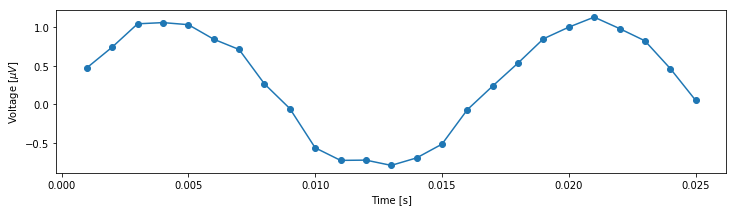

In [242]:
plot(t[:25], EEG[:25], 'o-')
xlabel('Time [s]')
ylabel('Voltage [$\mu V$]')
show()

Although the true brain signal may evolve as a continuous voltage trace in time, we do not observe this true signal. Instead, we observe a discrete sampling of this signal in time. The spacing between these samples is determined by the recording device collecting the EEG data. In this case, our collaborator has told us that the data are sampled at 1000 Hz, which corresponds to a sample of data every 1 ms. So, we observe not the (presumably) continuous true voltage signal, but instead discrete samples of this signal in time. 

To understand the impact of this discrete sampling, we first require some definitions. Let’s define $\Delta$ as the time between samples, in this case $\Delta = 1$ ms. We also define $N$ as the total number of points observed, and T as the total time of the recording. These three terms are related: $T = N \Delta$. For the $T = 2$ s of EEG data, there are $N = T/dt = 2/0.001 = 2000$ points. From this, we can also define the sampling frequency $f0 = 1/\Delta$ which in this case is 1000 Hz. Finally, we define a symbol for the data, $x$, which we also write as $x_n$ to explicitly indicate the index $n \in \{1, 2, 3, . . .N\}$ corresponding to the sample number. Let’s also define all of these variables in Python:

In [243]:
x = EEG  # Relabel the data variable
dt = t[1] - t[0]  # Define the sampling interval
N = x.shape[0]  # Define the total number of data points
T = N * dt  # Define the total duration of the data

We will need to keep the sampling interval   and the total recording duration T in mind - both will serve fundamental roles in our characterization of the rhythmic activity.

<div class="alert alert-block alert-info">
**Q.** In the second line of the code above we define the sampling interval as `dt=t[1] - t[0]`. How else could we have defined `dt`? Would `t[10] - t[9]` be appropriate?
</div>

### Step 2: Mean, variance, and standard deviation<a id="mean"></a>

As a first step in our analysis of the EEG data, let’s define two of the simplest measures we can use to characterize data $x$: the mean and variance<sup title="We could instead write the sample mean, because we use the observed data to estimate the theoretical mean that we would see if we were to keep repeating this experiment. This distinction is not essential to our goals here, but is important when talking to your statistics-minded colleagues. Throughout this chapter and others, we omit the term “sample” when referring to sample means, variances, covariances, and so forth, unless this distinction becomes essential to our discussion.">*note*</sup>. To estimate the mean $\overline x$, or average value, of $x$ we compute,

<p title="Mean">$$ \overline x = \frac{1}{N}\sum_{n=1}^N x_n. $$</p>

In words, we sum the values of $x$ for all $n$ time indices, then divide by the total number of points summed ($N$). To estimate the variance $\sigma^2$ of $x$ we compute,

<p title="Variance">
$$ \sigma^2 = \frac{1}{N}\sum_{n=1}^N (x_n - \overline x)^2,$$
</p>

which characterizes the extent of fluctuations about the mean. The *standard deviation* is simply the square root of the variance (i.e., $\sigma$). It's straightforward to compute all three quantities on an `ndarray` in Python:

In [244]:
mn = x.mean()  # Compute the mean of the data
vr = x.var()   # Compute the variance of the data
sd = x.std()   # Compute the standard deviation of the data

print('mn = ' + str(mn))
print('vr = ' + str(vr))
print('sd = ' + str(sd))

mn = 2.731148640577885e-17
vr = 0.5047172407856452
sd = 0.7104345436320261


<div class="alert alert-block alert-warning">
**A note on data types:** As used above, `mean()`, `var()`, and `std()` are methods of a type of variable called an *ndarray* (use `type(x)` to see what type of variable `x` is). The SciPy `loadmat()` function automatically imports variables to this data type, but it is likely that you will end up working with other data types as well. If you find that `x.mean()` produces an error, `x` is probably not an ndarray. In this case you should import the `numpy` module and either convert your variable to an ndarray using `numpy.array(x)`, or calculate the mean using `numpy.mean(x)`.
</div>

<div class="alert alert-block alert-info">
**Q.** Compare the mean computed above with the plot of the EEG data. Are the two consistent? How does the standard deviation compare with the EEG fluctuations in the plot?<br><br>

**A.** The computed mean is approximately 0. Visual inspection of the plot suggests that the EEG data fluctuates around a center value of 0, so the computed mean is consistent with our visual inspection of the data. The computed standard deviation is approximately 0.71. We expect that most of the signal fluctuations lie within two standard deviations (i.e., $\pm 2\sigma$) of the mean. We therefore expect to observe EEG values mostly between 0 ± 1.4 = (−1.4, 1.4), which is in fact what we observe.
</div>

The mean and variance (and standard deviation) provide single numbers that summarize the EEG trace. In this case, these numbers are not particularly useful. Both may depend on many factors, including the electrical contact between the electrode and scalp surface, and the cognitive state of the subject. Here, we’re more interested in how the EEG activity is distributed across rhythms. We’ve already begun to assess rhythms in the EEG data through visual inspection of the time series. To further characterize these rhythms, we will employ another powerful tool - the Fourier transform. However, before introducing the Fourier transform, we’ll first consider an intimately related measure: the autocovariance.

### Step 3: The autocovariance<a id="autocovariance"></a>

Our visual inspection strongly suggests a prominent feature in the data - rhythmic activity. Rhythmic activity represents a type of dependent structure in the data. For example, if we know the data tends to oscillate near 60 Hz, then given the value of the EEG data now, we can accurately predict the value of the EEG data 1/60 s in the future (i.e., one cycle of the 60 Hz activity); it should
be similar. One technique to assess the dependent structure in the data is the autocovariance. To start, let’s write down the formula for the autocovariance, $r_{xx}[L]$, evaluated at lag $L$,

<a id="eq:3.3"></a>
$$r_{xx}[L] = \frac{1}{N}\sum_{n=1}^{N-L}(x_{n+L} - \bar x)(x_n - \bar x).$$

In words, the autocovariance multiplies the data $x$ at index $n + L$, by the data $x$ at index $n$, and sums these products over all indices $n$. Notice that, in both terms, the mean value $\bar x$ is subtracted from $x$ before computing the product, and we divide the resulting sum by the total number of data points in $x$. We note that this is a *biased* estimate of the autocovariance; we compare this to an unbiased estimate of the autocovariance in the Supplement entitled [*Biased versus unbiased autocovariance*](Supplement. Biased versus unbiased autocovariance.ipynb).

To gain some intuition for the autocovariance, let’s represent $x$ graphically as a one dimensional row vector. 

![cartoon of a row vector](imgs/3-3a.png "We imagine the data x as a one-dimensional vector with indices n = {1,2,3,...N}.")

For the case $L = 0$, the autocovariance is simply the element-by-element product of x with itself, summed over all indices.

![autocovariance at lag 0](imgs/3-3b.png "The autocovariance at lag 0. To compute the autocovariance, we sum the multiplied elements, and then divide by N (the total number of data points).")

For the case $L = 1$, we shift $x$ by one index, multiply element-by-element the original (unshifted) $x$ by the shifted version, and sum over all indices.

![autocovariance at lag 1](imgs/3-3c.png "The autocovariance at lag 1. To compute the autocovariance, we sum the multiplied elements, and then divide by N (the total number of data points). Gray index labels at the beginning and end of each vector indicated data points not involved in computing the autocovariance at the chosen lag L.")

This process of shifting, element-by-element multiplying, and summing can be repeated for both positive and negative values of the lag $L$. Notice that, for larger values of $L$, we lose values at the beginning and ends of the autocovariance.

![autocovariance at lag 2](imgs/3-3d.png "The autocovariance at lag 2. To compute the autocovariance, we sum the multiplied elements, and then divide by N (the total number of data points). Gray index labels at the beginning and end of each vector indicated data points not involved in computing the autocovariance at the chosen lag L.")

<div class="alert alert-block alert-info">
**Q.** What is the largest reasonable value of $L$ to consider? For example, dow a value of $L$ greater than $N$ make sense?
</div>

The autocovariance will be largest at the lag $L$ for which the values of x "match". For most functions the autocovariance is largest at $L = 0$ (of course $x$ matches itself with zero shift), and tends to decrease as the magnitude of $L$ increases. Physically, the decrease in autocovariance with lag is consistent with the notion that data becomes less similar as time progresses. For example, in an EEG recording, we expect the activity now to be similar to the activity in the immediate future, but different from the EEG activity in the more distant future; as the brain responds to different internal and external cues, we expect different EEG activities to emerge, and associations between the EEG activity now and later to decay. Functions $x$ that exhibit dependent structure possess informative features in the autocovariance, as we’ll see for the EEG data in a moment.

<div class="alert alert-block alert-info">
**Q.** Compare the [autocovariance](#autocovariance) at $L=0$ and the [standard deviation](#mean). Notice anything similar?
</div>

To compute the autocovariance of the EEG data, we execute the following commands<a id="fig:3-4a"></a>

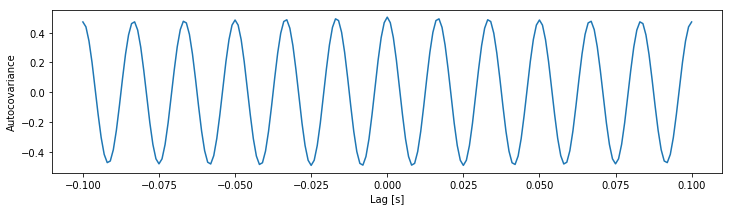

In [245]:
import numpy as np
# Compute the lags for the full autocovariance vector
lags = np.arange(-len(x) + 1, len(x))
# ... and the autocov for L +/- 100 indices
ac = 1 / N * np.correlate(x - x.mean(), x - x.mean(), mode='full')
# Find the lags that are within 100 time steps
inds = np.abs(lags) <= 100
# ... and plot them
plot(lags[inds] * dt, ac[inds])
# ... with axes labelled
xlabel('Lag [s]')
ylabel('Autocovariance')
show()

<div class="alert alert-block alert-info">
**Q.** Examine the plot of the autocovariance of the EEG data. What do you observe?
</div>

Notice that the first input to the function `correlate` is the EEG data with the mean subtracted (`x - mean(x)`). One striking feature of the autocovariance is the periodicity. A careful inspection shows that the autocovariance exhibits repeated peaks and troughs approximately every 0.0166 s.

<div class="alert alert-block alert-info">
**Q.** Why does the autocovariance exhibit repeated peaks and troughs approximately every 0.0166 s?<br><br>

**A.** The autocovariance is reflective of the dominant rhythmic activity in the data. Remember that the EEG data are dominated by a 60 Hz rhythm ([figure](#fig:3-1)). To gain intuition for how this rhythmic activity affects the autocovariance, we can also plot examples of the EEG data aligned with different lags $L$. 
</div>

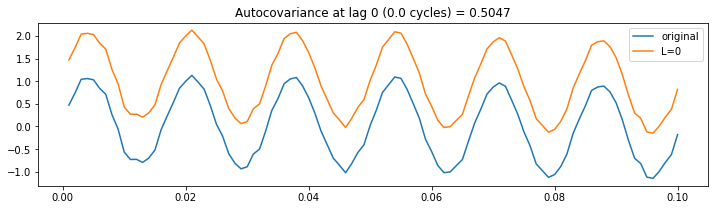

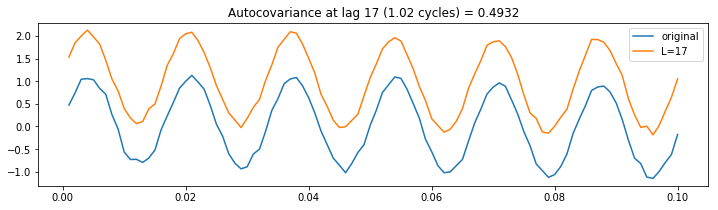

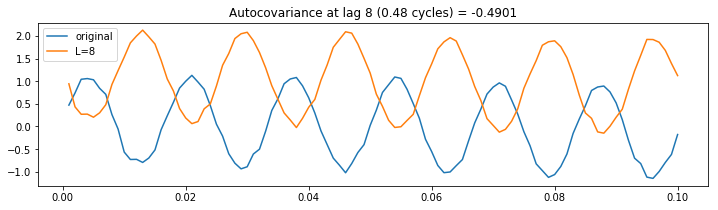

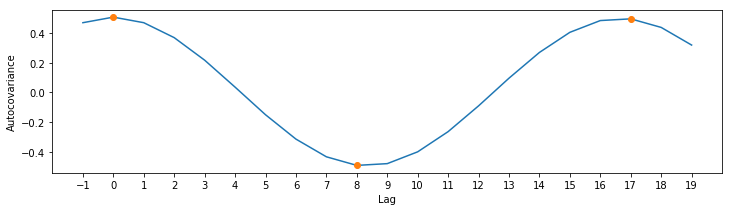

In [246]:
inds = range(100)   # Plot 100 observations
shift = [0, 1, .5]  # Shift by different proportions of a cycle
samples_per_cycle = 1000 / 60  # (samples per second) / (cycles per second)
L = [int(np.round(samples_per_cycle * s)) for s in shift]  # compute shifts
for l in L:         # for each shift
    plt.figure()    # ... make a new plot
    plot(t[inds], x[inds], label="original")  # ... plot the original
    plot(t[inds], x[[i + l for i in inds]] + 1, # ... and the shifted traces
         label="L={}".format(l))  # ... label the traces
    plt.legend()    # ... and show the legend
    plt.title("Autocovariance at lag {} ({} cycles) = {:0.4f}".format(l, l / samples_per_cycle, ac[(lags==l).argmax()]))
    show()

# Plot the autocovariance again, highlighting lags at different
# shifts in the 60 Hz cycle
inds = [l in range(-1, 20) for l in lags]
plot(lags[inds], ac[inds])
plot(sorted(L), ac[[l in L for l in lags]], 'o')
plt.xticks(range(-1, 20))
xlabel('Lag')
ylabel('Autocovariance')
show()

<div class="alert alert-block alert-success">
At zero lag ($L = 0$), the two time series are identical. Therefore, the product

$$(x_{n+0} - \bar x)(x_n - \bar x) = (x_n - \bar x)(x_n - \bar x) = (x_n - \bar x)^2$$

is non-negative for all indices $n$ (note that the product may sometimes be zero, but it’s never negative). To compute the autocovariance, we sum this product over all indices $n$, and divide by $N$, as defined [in the equation for the autocovariance](#autocovariance). Because we sum many positive terms, we expect to find a large positive value for $r_{xx}[0]$. Shifting the EEG data by an integer multiple of the 60 Hz cycle, we again observe a similar voltage trace. Therefore, at this lag $L$, we again expect the summed product

$$(x_{n+L} - \bar x)(x_n - \bar x)$$

over all indices $n$ to be large, and to find a large positive value for $r_{xx}[L]$ . In fact, we expect the autocovariance to be large and positive whenever the lag $L$ is an integer multiple of the 60 Hz cycle (i.e., an integer multiple of 1/60 ≈ 0.0166 s); this is exactly what we find in the [plot](#fig:3-4a) of the autocovariance.

Shifting the EEG data by half of the 60 Hz cycle, we observe a different type of relationship; at this lag, let’s call it $L^∗$, positive values in the unshifted EEG correspond to negative values in the shifted EEG. Therefore, most terms in the product
$$(x_{n + L^*} - \bar x)(x_n - \bar x)$$
are negative, and summing up these terms to compute the autocovariance we find a large negative value for $r_{xx}[L^*]$.
</div>

The autocovariance is a useful tool for assessing the dependent structure in the EEG data. Visual inspection of the EEG reveals a specific type of dependent structure – a strong rhythmic component – in the data. This dependent structure is further characterized in the autocovariance, in which the dominant 60 Hz activity manifests as periodic peaks and troughs in the autocovariance. In the next section, we consider a second tool – the spectrum – for assessing dependent structure in time series data. As we’ll see, the autocovariance and spectrum are intimately related in a remarkable way.

### Step 4: Power spectral density, or spectrum<a id="power-spectral-density"></a>
There are many techniques to assess rhythmic activity in the EEG data. Here, we compute the *power spectral density*, or simply the *spectrum*, of $x$ using a well-established technique, the *Fourier transform*. There are many subtleties associated with computing and interpreting the spectrum. We explore some of them here; in doing so, we build our intuition for spectral analysis and our ability to deal with future, unforeseen circumstances in other data we encounter in research.

<div class="alert alert-block alert-info">
**Note.** 
<p>The *spectrum* of the data $x$ is the magnitude squared of the Fourier transform of $x$. The spectrum indicates the amplitude of rhythmic activity in $x$ as a function of frequency.</p>

<p>The *power spectral density* describes the extent to which sinusoids of a single frequency capture the structure of the data. To compute the power over any range of frequencies, we would integrate (or for discrete frequencies, sum) the spectrum over that frequency range.</p>

</div>

<a id="spectrum"></a>
**Computing the spectrum.** We start by presenting all the formulas and code necessary to compute the spectrum of the data. Then throughout the chapter, we circle back and consider each step of the computation in detail.

We first need a formula for the discrete-time Fourier transform of the data x:<a id="eq:3.8"></a>

$$X_j = \sum_{n=1}^N x_n exp(-2 \pi i f_j t_n).$$

The Fourier transform computes the sum over all the time indices $t_n = \Delta\{1, 2, 3, ..., N\}$ of the data $x_n$ multiplied by sinusoids oscillating at a given frequency $f_j = j / T$, where $j = \{N/2 + 1, -N/2 + 2, ..., N/2 - 1, N/2\}$. The result is a new quantity $X_j$, the signal as a function of frequency $f_j$ rather than time $t_n$. The spectrum is then <a id="eq:3.9"></a>

$$S_{xx, j} = \frac{2\Delta^2}{T}X_j X_j^*,$$

which is the product of the Fourier transfrom of $x$ with its complex conjugate (indicated by the superscript $*$), scaled by the sampling interval and the total duration of the recording. The term $w\Delta^2/T$ is simply a numerical scaling (see appendix C **TBD add link**) The units of the spectrum are, in this case, (\mu V)^2/Hz. Computing the spectrum in Python requires only a few lines of code:<a id="fig:3.6"></a>

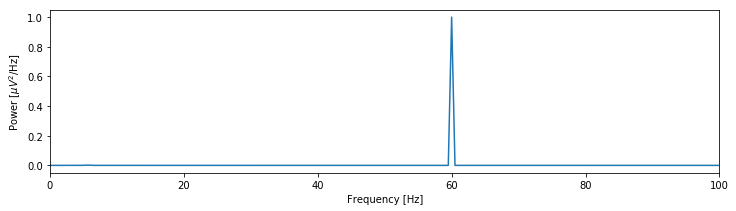

In [247]:
xf = np.fft.fft(x - x.mean())  # Compute Fourier transform of x
Sxx = 2 * dt ** 2 / T * (xf * np.conj(xf))  # Compute spectrum
Sxx = Sxx[:int(len(x) / 2)]  # Ignore negative frequencies

df = 1 / T.max()  # Determine frequency resolution
fNQ = 1 / dt / 2  # Determine Nyquist frequency
faxis = np.arange(0,fNQ,df)  # Construct frequency axis

plt.plot(faxis, np.real(Sxx))  # Plot spectrum vs frequency
plt.xlim([0, 100])  # Select frequency range
xlabel('Frequency [Hz]')  # Label the axes
ylabel('Power [$\mu V^2$/Hz]')
plt.show()

That’s not so bad; the code to compute and display the spectrum fits in 13 lines (with spacing for aesthetics). Notice the large peak at 60 Hz. This peak is consistent with our visual inspection of the EEG data, in which we approximated a dominant rhythm at 60 Hz by counting the number of peaks that appeared in the voltage traces. So, our computation of the spectrum at least matches our initial expectation deduced from visual inspection of the data.

We’ve managed to compute and plot the spectrum, and our analysis results match our expectations. We could choose to stop here. But a danger persists: we’ve blindly entered MATLAB code and achieved an expected result. What are the frequency resolution and Nyquist frequency mentioned in the comments of the code? Maybe this procedure is fraught with pitfalls, and we simply got lucky in this case? Does the spectrum provide additional information that was not immediately uncovered? How will we react and adapt when the spectrum results do not match our intuition? To answer these questions requires developing more intuition for the Fourier transform and spectrum. In the following sections, we examine equations for the Fourier transform (<a href="#eq:3.8" class="thumb">eq.<span><img src="imgs/eq3-8.png"></span></a>) and spectrum (<a href="#eq:3.9" class="thumb">eq.<span><img src="imgs/eq3-9.png"></span></a>), and the Python code. In doing so, we explore some subtleties of this measure and strengthen our intuition for this measure’s behavior. Building this intuition is perhaps the most important part for dealing with unforeseen circumstances arising in your own data.

##### What is the Fourier transform actually doing?
The Fourier transform represents the data x as a linear combination of sinusoids with different frequencies. To see this, consider again:

$$X_j = \sum_{n=1}^{N}x_n exp(-2\pi i f_j t_n).$$

What is this expression actually doing? Let's consider this equation piece by piece. The first term,

$$\sum_{n=1}^N$$

represents a sum over the indices of $x_n$. Because each subsequent index represents a step forward in time of $\Delta$, this sum represents a sum over time. In fact, this sum extends from the first index ($n=1$) to the last index ($n = N$) of the data, so the summation occurs over the entire duration fo the recording. Adding the second term,

$$\sum_{n=1}^N x_n$$,

the summation now acts on the data $x_n$, so we're summing up the data over all indices or equivalently over the entire time of recording. The third ter, 

$$\exp(-2\pi i f_j t_n),$$

consists of an exponential (exp) operating on the product of five individual terms, each of which is a number. The first two numbers are simple: $-2 \pi$. The third number is $i \equiv \sqrt{-1}$, a quantity representing an *imaginary unit*. The utility of the imaginary unit is that we can rewrite the exponential as the sum of a sine and cosine function. Remember from caclulus the remarkable Euler's formula:

$$\exp(-2\pi i f_j t_n) = \cos(-2\pi f_j t_n) + i \sin(-2\pi f_j t_n).$$

Notice that the $i$ now appears multiplying the sine term, and not inside the arguments of either sinusoid. Both sinusoids operate on the product of $2\pi$ and two terms, the frequency $f_j$ and the time $t_n$. Rewriting the equation for the Fourier transform using Euler's formula, we find<a id="eq:3.10"></a>

\begin{equation}\tag{10}\label{eq:10}
X_j = \left(\sum_{n=1}^N x_n \cos(-2\pi f_j t_n) \right) + i\left(\sum_{n=1}^N x_n \sin(-2\pi f_j t_n)\right), 
\end{equation}

where the summation is distributed over both terms.

Written in this way, the Fourier transform becomes easier to interpret. Let’s consider the
first term of the equation above. For each index $n$, we multiply the data $x_n$ by a cosine function evaluated at frequency $f_j$ and time $t_n$. We then sum the results of this multiplication over all indices from $n=1$ to $n=N$, or equivalently, from time $t_n = 1$ to time $t_n =T$. So, we multiply the data by a cosine function at frequency $f_j$ for each point in time, and sum the product over time. The second term of the equation is like the first, except we multiply the data $x_n$ by a sine function.

We therefore think of the Fourier transform as comparing the data $x$ to the sinusoids oscillating at frequency $f_j$. When the data and sinusoid at frequency $f_j$ align the summation in the Fourier transform is large and the result $X_j$ is a large number. When the data and sinusoid at frequency $f_j$ do not align, the summation in the Fourier transform is small and $X_j$ is a tiny number. To make these ideas more concrete, we can consider some simple examples. In these examples, the data $x$ will be a perfect cosine with frequency 10 Hz.

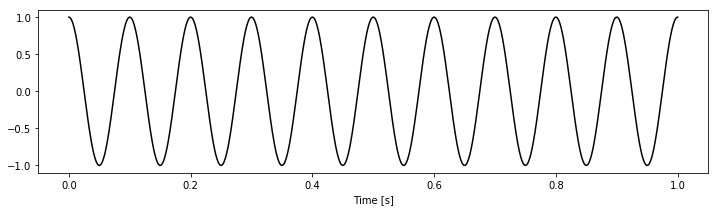

In [248]:
tt = np.linspace(0, 1, 1000)  # Create a time variable (in seconds)
x = np.cos(2 * np.pi * 10 * tt)  # Generate the data, a 10 Hz cosine
plot(tt, x, 'k')  # Plot the result
xlabel('Time [s]')
show()

Choosing $f_j = 4$ Hz, we can construct a sine and cosine function each oscillating at 4 Hz.

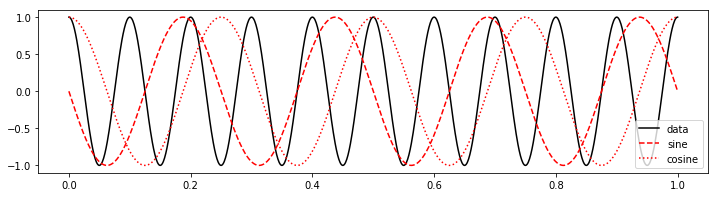

In [250]:
fj = 4  # Set frequency
fj_sin = np.sin(-2 * np.pi * fj * tt)  # construct sine wave
fj_cos = np.cos(-2 * np.pi * fj * tt)  # ... and cosine
plot(tt, x, 'k', label='data')  # Plot the data
plot(tt, fj_sin, 'r--', label='sine')  # ... and the sine
plot(tt, fj_cos, 'r:', label='cosine')  # ... and cosine
plt.legend()
show()

Then, to perform the calculation of the equation above (<a href="#eq:3.10" class="thumb">eq.<span><img src="imgs/eq3-10.png"></span></a>) we multiply the data $x$ by the sinusoids at each point in time.

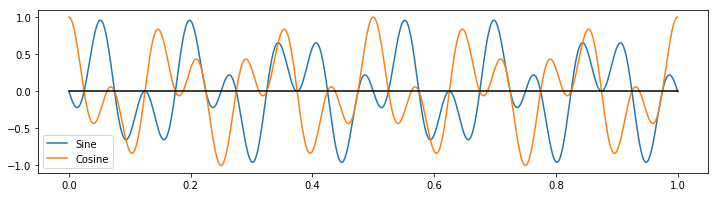

In [251]:
plot(tt, x * fj_sin, tt, x * fj_cos)  # Plot the product of x with the sinusoids
plt.legend(['Sine', 'Cosine'])
plot(tt, np.zeros_like(tt), 'k')  # Show zero
show()

Notice that the products alternate between positive and negative values throughout time. 

<div class="alert alert-block alert-info">
<p>**Q.** In this case, what is the approximate value of $X_j$ when $f_j = 4$ Hz?</p>
<br>
<p>**A.** We know that $X_j$ is the summation over time of the product of $x$ and the sinusoids (<a href="#eq:3.10" class="thumb">eq.<span><img src="imgs/eq3-10.png"></span></a>). Above, we plotted these products over time. Because each product alternates between positive and negative values roughly equally over time, the summation of the product over time is approximately zero. We therefore conclude that both the real part (i.e., the cosine term) and the imaginary part (i.e. the sine term) are small and $X_j \approx 0 + 0i$ when $f_j = 4$ Hz. </p>
</div>

In this case, the sinusoids at frequency $f_j = 4$ Hz do not align with the data $x$, and $X_j$ is nearly zero in both its real and imaginary parts. Now consider the case in which we choose $f_j = 10$ Hz. With this choice of $f_j$, the data $x$ and the cosine function align perfectly. 

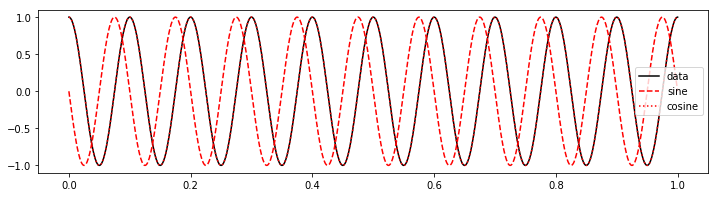

In [253]:
fj = 10  # Set the frequency
fj_sin = np.sin(-2 * np.pi * fj * tt)  # Construct the sine wave
fj_cos = np.cos(-2 * np.pi * fj * tt)  # ... and cosine wave

plot(tt, x, 'k', label='data')  # Plot the data
plot(tt, fj_sin, 'r--', label='sine')  # ... and the sine
plot(tt, fj_cos, 'r:', label='cosine')  # ... and cosine
plt.legend()
show()

<div class="alert alert-block alert-info">
**Q.** Can you predict how the plot of the product of the data with the overlapping cosine function will look? Plot the product and check your prediction.
</div>

The product of the cosine function and the data is always non-negative, and therefore its summation over time results in a large positive number. In this case, the real part of $X_j$ is large because the cosine function with frequency $f_j =10$ Hz and the data $x$ match. In this sense, the Fourier transform reveals the dominant frequencies of the underlying time series.

<div class="alert alert-block alert-info">
**Q.** What is the approximate value of the *imaginary* part of $X_j$ for $f_j = 10$ Hz? *Hint*: Consider the plot of the product of the sine function and the data.
</div>

##### Relation of the spectrum to the autocovariance.
We’ve now introduced two tools for assessing dependent structure in the EEG data: the autocovariance and the spectrum. Remarkably, these two measures are related in an important way.

<div class="alert alert-success">
The spectrum is the Fourier transform of the autocovariance.
</div>

The spectrum and autocovariance both assess dependent structure in the data but in different domains - the spectrum in the frequency domain and the autocovariance in the time domain. Notice that the spectrum $S_{xx, j}$ (<a href="#eq:3.9" class="thumb">eq.<span><img src="imgs/eq3-9.png"></span></a>) is a function of frequency index $j$, while the autocovariance $r_{xx}[L]$ (<a href="#eq:3.3" class="thumb">eq.<span><img src="imgs/eq3-3.png"></span></a>) is a function of time lag $L$. For the EEG data of interest here, the dominant 60 Hz rhythm manifests as periodicity in the autocovariance as a function of lag (<a href="#fig:3-4a" class="thumb">plot<span><img src="imgs/3-4a.png"></span></a>), and a peak in the spectrum as a function of frequency (<a href="#fig:3.6" class="thumb">plot<span><img src="imgs/3-6.png"></span></a>). Although the two measures are related through the Fourier transform, each provides a different perspective on the dependent structure in the data. In practice, applying and visualizing both measures is often of use. See appendix A **(TBD: add link)** for a more mathematical discussion of this relation.

Here’s an associated mathematical nugget. The spectrum is the Fourier transform of $x$ multiplied by its complex conjugate. That produces a real number (i.e., the imaginary part is 0), which is convenient for plotting and visualization. The autocovariance is necessarily symmetric with respect to lag, that is, $r_{xx}[L] = r_{xx}[-L]$. In other words, the autocovariance is an even function. The Fourier transform of an even function is real, so the Fourier transform of the autocovariance is also a real number, consistent with the values of the spectrum.

##### Relation of the Spectrum to Multiple Linear Regression
As a final perspective, we consider a statistical modeling approach, with the goal of characterizing the rhythms that appear in the EEG data. To develop this approach, we first introduce *linear regression*. The idea of linear regression is to express a response variable at time $n$ (call it $x_n$) in terms of predictor variables (call them $z_{1n}, z_{2n},...,z_{pn}$ for $p$ predictor variables) as <a id="eq:3.11"></a>

$$x_n = \beta_0 + \beta_1z_{1n} + \beta_2z_{2n} + ... + \beta_pz_{pn} + \epsilon_n,$$

where $\epsilon_n$ is a random variable. This formulation represents the model we use in *multiple linear regression*. The term multiple comes from the multiple predictors used. The term linear expresses the fact that each predictor appears linearly in the expression. The challenge is to identify the unknown coefficients (the  $\beta$’s) given the observed response and predictor variables. We note that the case of $p = 1$ corresponds to simple linear regression; in that case, the goal is to fit the line,

$$x_n = \beta_0 + \beta_1z_{1n} + \epsilon_N,$$

with slope $\beta_1$ and intercept $\beta_0$.

Let’s consider application of multiple linear regression to the EEG data with a specific
purpose: to remove the 60 Hz line noise. Recall that we found that the spectrum was dominated by a 60 Hz peak (<a href="#fig:3.6" class="fig">figure<span><img src="imgs/3-6.png"></span></a>). We expect this 60 Hz is due to electrical noise in the system, and this large noise peak may mask other interesting features occurring in the EEG data. Therefore, our analysis of the EEG data may benefit by removing this large 60 Hz signal. To do so, we first fit a multiple linear regression model to the data $x_n$ with the following form,<a id="eq:3.12"></a>

$$x_n = \beta_0 + \beta_1 \sin(2\pi 60 t_n) + \beta_2\cos(2\pi 60 t_n) + \epsilon_n,$$

where $x_n$ is the EEG data at index $n$, $t_n$ is the corresponding time axis at index $n$ in units of seconds, and $\epsilon_n$ is a random variable.

<div class="alert alert-block alert-info">
<p>**Q.** The model consists of three predictors. What are they?</p>
<p>**A.** The predictors are a constant term, a sine function at 60 Hz, and a cosine function at 60 Hz. Our goal is to solve for the unknown coefficients $\beta_0, \beta_1,$ and $\beta_2$ given the EEG data.</p>
</div>

To do multiple linear regression in Python we start by importing the `statsmodels` package and the `DataFrame` function from the `pandas` package. We use `DataFrame` to create a table that is easy to work with and then use `statsmodels` perform the regression.

In [254]:
import statsmodels.formula.api as smf
from pandas import DataFrame as df

The following code performs the multiple linear regression:

In [259]:
predictors = df(data={  # Create a dataframe with the predictors
    'sin': np.sin(2 * np.pi * 60 * t),  # ... including the sine function
    'cos': np.cos(2 * np.pi * 60 * t),  # ... and the cosine function
    'EEG': EEG
})

# Fit the model to the data
model = smf.ols('EEG ~ sin + cos', data=predictors).fit()
model.params

Intercept    2.746758e-17
sin          9.989204e-01
cos         -3.238373e-03
dtype: float64

In the first line we create a *dataframe* with the dependent variables (`EEG`) and independent variables (or predictors) of the model - in this case the 60 Hz sine function, and the 60 Hz cosine function. Next, we fit the model to the data using the `ols` function. OLS stands for ordinary least squares because Python determines the coefficients by minimizing the squared distance between the true and predicted data points. The last line shows us the values that Python has found for the $\beta$'s.

<div class="alert alert-block alert-info">
<p>**Q.** Examine the fitted $\beta$ values. What do you find?</p>

<p>**A.** We find
    
<div style="margin: .25in; background-color: #eff0f1">
<code>Intercept    2.746758e-17
sin          9.989204e-01
cos         -3.238373e-03
dtype: float64</code></div>

This result indicates that the constant predictor and the 60 Hz cosine predictor do not contribute much to the data; the values `Intercept` and `cos` are both near zero. However, the 60 Hz sine function makes a much larger contribution; the value `sin` is near 1.</p>
</div>

To see how well our multiple linear regression model fits the data, let’s evaluate the model, and compare it to the original EEG data:
<a id='fig:3.8'></a>

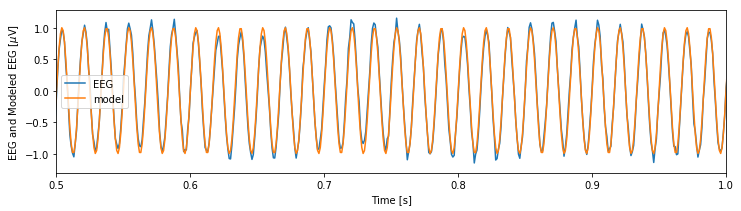

In [273]:
EEG_60Hz_modeled = model.predict()  # Get the model prediction
plot(t, EEG, t, EEG_60Hz_modeled)  # Plot the data and the model
plt.xlim([0.5, 1])  # ... examine 0.5 s of data,
xlabel('Time [s]')  # ... and label the axes
ylabel('EEG and Modeled EEG [$\mu$V]')
plt.legend(['EEG', 'model'])
show()

The model, which contains only three predictors, appears to do quite a good job at capturing the 60 Hz activity in the EEG data.

<div class="alert alert-block alert-info">
<p>**Q.** The multiple linear regression model (<a href="#eq:3.12" class="thumb">eq.<span><img src="imgs/eq3-12.png"></span></a>) is not a *perfect* fit ot the data. Why?</p>

<p>**A.** The multiple linear regression model includes only three predictors. We expect the EEG data to consist of other features, including rhythms at other frequencies. Therefore, this simple model cannot account for all features of the EEG time series. That’s okay. The goal of this model was to fit a particular rhythm, the 60 Hz activity, not every aspect of the data.</p>
</div>

Now, let's examine a powerful application of the model. We've constructed the model to fit the 60 Hz line noise in the EEG data. Let's now use the model to *remove* the 60 Hz line noise from the original EEG data. To do so, we subtract the model fit from the EEG data and then plot the resulting new signal: <a id="fig:3.9"></a>

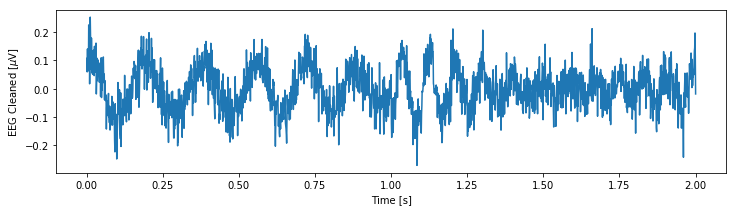

In [276]:
# Remove the model prediction from the EEG data
EEG_cleaned = EEG - EEG_60Hz_modeled
plot(t, EEG_cleaned)  # ... and plot the result
xlabel('Time [s]')
ylabel('EEG Cleaned [$\mu$V]')
show()

<div class="alert alert-block alert-info">
**Q.** Consider the cleaned EEG data. What activity do you now notice? Compare the EEG data in this plot to the original EEG data (<a href="#fig:3-1" class="fig">figure<span><img src="imgs/3-1.png"></span></a>), which includes the 60 Hz noise. What’s different?
</div>

In this example, we used multiple linear regression to model a particular rhythmic component of the EEG data, the 60 Hz activity. We may also use the model result to estimate the power at 60 Hz. In Python,

In [283]:
Sxx_model_60Hz = model.params['sin'] ** 2 + \
                 model.params['cos'] ** 2
Sxx_model_60Hz

0.9978524145209717

The power estimate from the model consists of two terms: the squared coefficient of the sine function plus the squared coefficient of the cosine function. Note that the variable `Sxx_model_60Hz` has units of $mV^2$.

<div class="alert alert-block alert-info">
**Q.** Compare the power estimate from the model (the variable `Sxx_model_60Hz`) to the power spectral density at 60 Hz computed using the Fourier transform (<a href="#eq:3.9">code</a>). What do you find?
<br><br>
**A.** We note that the units of the power spectral density (variable `Sxx`) are $mV^2/Hz$, while the units of the power estimated in variable `Sxx_model_60Hz` are $mV^2$. To convert the power spectral density to (integrated) spectral power, we must integrate the variable `Sxx` over a frequency range. Here, we choose a 1 Hz interval centered at 60 Hz, which corresponds to a single index of the variable `faxis`; the frequency resolution for these data is 0.5 Hz (see next section). Then the approximate integrated power over this 1 Hz interval is `Sxx(121)=0.9979`, identical to the value in Sxx_model_60Hz, and with the same units.
</div>

This example, in which we focused on the 60 Hz activity in the EEG, illustrates how we may use multiple linear regression to estimate the power. We could extend this procedure to include additional rhythms in the model beyond 60 Hz (e.g., sine and cosine functions at 1 Hz, 2 Hz, 3 Hz, etc.). In doing so, we would add more terms to the multiple linear regression model and have more $\beta$'s to determine from the data. Multiple linear regression provides a way to decompose the EEG data into sine and cosine functions at different frequencies—just as we proposed to do using the Fourier transform—and then compute the power at each frequency. Using either multiple linear regression or the Fourier transform, we aim to decompose the EEG into sine and cosine functions oscillating at different frequencies.

#### Discrete Fourier Transform in Python <a id="dft"></a>

Computing the spectrum of a signal $x$ in Python can be achieved in two simple steps. The first step is to compute the Fourier transform of $x$:

In [327]:
x = EEG
xf = np.real(np.fft.rfft(x - x.mean()))

We subtract the mean from `x` before computing the Fourier transform. This is not necessary but often useful. For these neural data, we’re not interested in the very slow (0 Hz) activity; instead, we’re interested in rhythmic activity. By subtracting the mean, we eliminate this low-frequency activity from the subsequent analysis.

The second step is to compute the spectrum, the Fourier transform of $x$ multiplied by its complex conjugate:<a id="fig:3.10"></a>

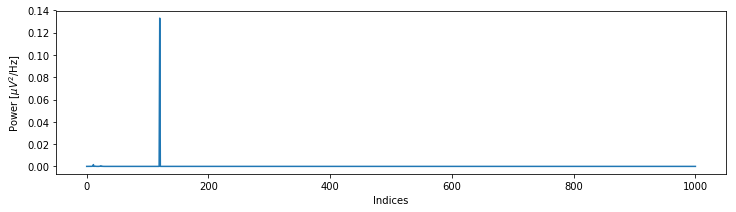

In [329]:
Sxx = 2 * dt ** 2 / T * (xf * np.conj(xf))
plot(Sxx)
xlabel('Indices')
ylabel('Power [$\mu V^2$/Hz]')
show()

<div class="alert alert-block alert-warning">
**TBD: FIX THIS**
*The MATLAB fft function doesn't assume tha tthe input is real, but Python rfft does this, so there is no need for all of this exposition, but still some might be useful.*
<br>
<br>

Upon examining the horizontal axis in this plot, we find it corresponds to the indices of `x`, beginning at index 0 and ending at index `N = 1999`. Computing the Fourier transform and multiplying by the complex conjugate does not change the length of the data `x`.

Inspection of the plot above reveals a strange characteristic: there are two large peaks, and the plot exhibits a particular symmetry. If we were to cut this plot from a printed page and fold the resulting piece of paper at index 1000, we would find that the two peaks in Sxx align; both peaks appear to be the same number of indices away from the center index 1000. This suggests that a redundancy occurs in the variable `Sxx`. In fact, this redundancy is due to the way the `fft` module relates the indices and frequencies of `Sxx`. To define this relation requires two new quantities:

* the *frequency resolution*, $df = \frac{1}{T}$, or the reciprocal of the total recording duration;
* the *Nyquist frequency*, $f_{NQ} = \frac{f_0}{2} = {1}{2\Delta}$, or half of the sampling frequency $f_0 = \frac{1}{\Delta}$.

For the clinical EEG data considered here, the total recording duration is 2 s ($T = 2$ s), so the frequency resolution $df = 1 / (2\ s) = 0.5\ Hz$. The sampling frequency $f_0$ is 1000 Hz, so $f_{NQ} = 1000 / 2\ Hz = 500\ Hz$. There's much more to say about both quantities, but for now let's simply use both quantities to consider how Python relates the indices and frequencies of the vector `Sxx`.

<a id="tbl:3.1"><img src="imgs/tbl3-1.png"></a>

For the first half of `Sxx`, the frequency axis increases in steps of the frequency resolution $df$ (here, 0.5 Hz) until reaching the Nyquist frequency $f_{NQ}$ (here, 500 Hz). This maximal frequency occurs just past the halfway point of the indices, at index $j = N/2 + 1$. Beyond this index, the frequency axis is negative, and the magnitude of the frequency becomes smaller and smaller until the value $-df$ is reached at index $j = N$.

We may now utilize a useful property of the Fourier transform. When a signal is real (i.e., the signal has zero imaginary component), the negative frequencies in the spectrum are redundant. So, the power we observe at frequency f0 is identical to the power we observe at frequency  f0. For this reason, we can safely ignore the negative frequencies; these frequencies provide no additional information. Because the EEG data are real, we conclude that the negative frequencies in the variable Sxx are redundant and can be ignored. As a specific example, the value of Sxx at index j = 3 is the same as the value of Sxx at index j = N   1; these indices correspond to frequencies 2df and  2df , respectively (see table 3.1). We therefore need only plot the variable Sxx for the positive frequencies, more specifically, from index 1 to index N/2 + 1. This conclusion matches our visual inspection of Sxx in figure 3.10.

</div>

Given the total duration of the recording ($T$) and the sampling frequency ($f_0$) for the data, we can define the frequency axis for the spectrum `Sxx`. Now, to compute and plot the spectrum, we again utilize some code introduced earlier:

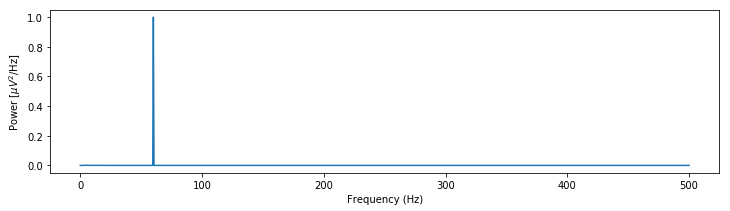

In [325]:
xf = np.fft.rfft(x - x.mean())
Sxx = np.real(2 * dt ** 2 / T * (xf * np.conj(xf)))
df = 1 / T
fNQ = 1 / dt / 2
faxis = np.arange(len(Sxx)) * df
plot(faxis, Sxx)
xlabel('Frequency (Hz)')
ylabel('Power [$\mu V^2$/Hz]')
show()

In the next two section, we focus on interpreting and adjusting the quantities $df$ and $f_{NQ}$. Doing so is critical to develop further an intuition for the spectrum.

#### The Nyquist frequency, $f_{NQ}$ <a id="nyquist-frequency"></a>

The formula for the Nyquist frequency is <a id="eq:3.13"></a>

$$f_{NQ} = \frac{f_0}{2}.$$

The Nyquist frequency is the highest frequency we can possibly hope to observe in the data. To illustrate this, let’s consider a true EEG signal that consists of a very simple time series—a pure sinusoid that oscillates at some frequency $f_s$. Of course, we never observe the true signal. Instead, we observe a sampling of this signal, which depends on the sampling interval $\Delta$. We consider three cases for different values of $\Delta$. In the first case, we purchase a very expensive piece of equipment that can sample the true signal at a high rate, $f_0 \gg f_s$. In this case, we cover the true brain signal with many samples and given these samples, we can accurately reconstruct the underlying data.

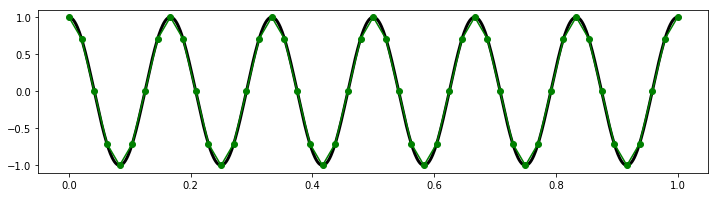

In [336]:
tempfs = 6
pi = np.pi
tempsmooth = np.linspace(0,1,1000)
tempx = np.linspace(0, 1, 8*tempfs + 1)
tempyx = np.cos(2 * pi * tempfs * tempx)
tempysm = np.cos(2 * pi * tempfs * tempsmooth)

plot(tempsmooth, tempysm, 'k', lw=3)
plot(tempx, tempyx, 'go-')
show()

####  The frequency resolution<a id="frequency-resolution"></a>

### Step 5: Decibel scaling<a id="decibel-scaling"></a>

### Step 6: The spectrogram<a id="the-spectrogram"></a>

 Details and intuitions behind each step are proved in the supplement entitled [*Intuition behind the power spectral density*](Supplement. Intuition behind the power spectral density.ipynb).